## In this notebook we will look at a sparse, unbalanced dataset, balance it with under-sampling and with SMOTE, and use several machine learning algorithms to attempt to classify the data.

In [2]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import preprocessing, svm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, auc
import random
import matplotlib.pyplot as plt
import collections
from sklearn.naive_bayes import GaussianNB

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score, precision_recall_curve
from sklearn.decomposition import SparsePCA, TruncatedSVD

from xgboost import XGBClassifier


In [3]:
df = pd.read_csv("../train.csv")
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56020 entries, 0 to 56019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 158.6 MB
None


In [4]:
fraudocc = df['TARGET'].value_counts()
print(fraudocc)

print("Ratio of fraud cases:")
print(fraudocc/len(df))

0    53814
1     2206
Name: TARGET, dtype: int64
Ratio of fraud cases:
0    0.960621
1    0.039379
Name: TARGET, dtype: float64


In [5]:
df.describe()

,ID,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_360,var_361,var_362,var_363,var_364,var_365,var_366,var_367,var_368,TARGET
count,56020.000000,56020.000000,56020.000000,56020.000000,56020.000000,56020.000000,56020.000000,56020.000000,56020.000000,56020.000000,...,56020.000000,56020.000000,56020.000000,56020.000000,56020.000000,56020.000000,56020.000000,56020.000000,5.602000e+04,56020.000000
mean,38006.087701,-1478.918761,33.176455,90.577048,71.914411,118.527881,3.308784,5.980358,0.351521,0.534811,...,7.061389,1.186156,12.682248,8.813963,33.439499,1.724232,76.339788,56.126032,1.170350e+05,0.039379
std,21965.342957,38463.619817,12.925293,1779.782881,338.520271,541.712773,89.095332,145.400358,19.645287,30.005879,...,427.464112,110.490491,852.152706,571.506477,2282.092562,146.961440,4244.942998,2960.886733,1.868549e+05,0.194496
min,0.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,18941.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.792923e+04,0.000000
50%,38044.500000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.065634e+05,0.000000
75%,57075.250000,2.000000,39.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.188930e+05,0.000000
max,76019.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,1800.000000,3810.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


In [6]:
#It looks like -999999.000000 is the assignment for a NaN
df=df.replace(-999999.000000,np.nan)
df.isnull().values.any()

True

In [7]:
df[(df.isnull().any(axis=1)) & (df["TARGET"]==1)]

,ID,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_360,var_361,var_362,var_363,var_364,var_365,var_366,var_367,var_368,TARGET
40206,54652,NaN,28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,1


In [8]:
# Since there are only 83 points and of them just 1 is a signal event, it should be safe to drop all the rows with NaN values
df=df.dropna()
df.shape

(55937, 371)

In [9]:
df[df["var_0"]==238.] #examine the high point in var_0
df[df["var_366"]==681462.9] #examine the high point in var_0
df[df["var_1"]==5.]

,ID,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_360,var_361,var_362,var_363,var_364,var_365,var_366,var_367,var_368,TARGET
74,90,0.0,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,102074.610000,0
3130,4254,0.0,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89179.080000,0
6146,8321,0.0,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,211208.640000,0
12602,17081,0.0,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,219890.190000,0
20126,27188,0.0,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,140672.520000,0
20563,27791,0.0,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,162167.160000,0
21767,29441,0.0,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,119238.720000,0
24241,32821,0.0,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,449661.840000,0
26852,36444,0.0,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,277721.370000,0
27352,37128,0.0,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,121513.230000,0


It doesn't look like the extreme values in the columns necessarily indicate a signal

In [10]:
# Define functions to find the pairs of columns with highest correlation.
def get_redundant_pairs(df1):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df1.columns
    for i in range(df1.shape[1]):
        for j in range(0, i):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df1, n=5):
    au_corr = df1.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df1)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n], labels_to_drop

In [11]:
target = df.TARGET
predictors=df.drop(columns=['ID','TARGET'])

183


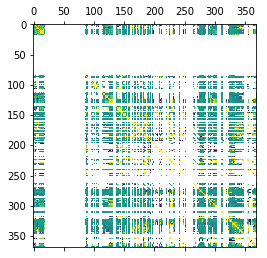

In [12]:
#The high number of 0's will affect the correlation matrix, calculate the correlation by replacing 0's with NaN.

pred_NaN = predictors.replace(0,np.nan)
plt.matshow(pred_NaN.corr())
correlationsNaN, corrLabelsNaN = get_top_abs_correlations(pred_NaN, 10000)

correlationListNaN = list(zip(corrLabelsNaN, correlationsNaN))

removeListNaN=[]
safeListNaN=[]
for i in range(len(correlationListNaN)):
    if correlationListNaN[i][1]<0.95:
        if correlationListNaN[i][0][0] in safeListNaN or correlationListNaN[i][0][0] in removeListNaN or correlationListNaN[i][0][1] in removeListNaN or correlationListNaN[i][0][1] in safeListNaN: continue 
        safeListNaN.append(correlationListNaN[i][0][0])
        removeListNaN.append(correlationListNaN[i][0][1])
print(len(removeListNaN))

In [13]:
# Now we have  a list of highly correlated samples that we can remove if we want to later
# Now we have to scale the columns to make sure one column with large values doesn't have 
# a disproportionate effect on the model.  We'll scale both the original set and the set 
# with correlations removed and test both.  Also check for NaN after scaling in case we divide by 0 somewhere.

pred_scaled=pd.DataFrame(sklearn.preprocessing.minmax_scale(predictors))
print(pred_scaled.describe())
pred_scaled.isnull().values.any() #check for any place we might have divided by 0

/Users/ian/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64.
  


                0             1             2             3             4    \
count  55937.000000  55937.000000  55937.000000  55937.000000  55937.000000   
mean       0.011334      0.281743      0.000432      0.005585      0.005643   
std        0.039301      0.129270      0.008481      0.026278      0.025779   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.008403      0.180000      0.000000      0.000000      0.000000   
50%        0.008403      0.230000      0.000000      0.000000      0.000000   
75%        0.008403      0.340000      0.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

                5             6             7             8             9    \
count  55937.000000  55937.000000  55937.000000  55937.000000  55937.000000   
mean       0.000402      0.000541      0.000196      0.000141      0.000358   
std        0.010823      0.013140      0.010922    

False

### Now we have to balance the data, since ML algorithms don't work well on very unbalanced datasets.  We will do this two ways: under-sample the majority class and synthesize new data points for the minority class and then compare the results.

In [14]:
rus = RandomUnderSampler(random_state=0)
X_undersampled, y_undersampled = rus.fit_resample(pred_scaled, target)

In [15]:
# Check that undersampling worked:
len([i for i in y_undersampled if i==1]) == len([i for i in y_undersampled if i==0])

True

In [16]:
method = SMOTE(kind='regular')

# Create the resampled feature set
X_oversampled, y_oversampled = method.fit_sample(pred_scaled, target)

In [17]:
# Check that oversampling worked:
len([i for i in y_oversampled if i==1]) == len([i for i in y_oversampled if i==0])

True

In [18]:
# Set up out training and validation sets
X_train_us, X_test_us, y_train_us, y_test_us = train_test_split(X_undersampled, y_undersampled, test_size=0.3, random_state=0)
X_train_os, X_test_os, y_train_os, y_test_os = train_test_split(X_oversampled, y_oversampled, test_size=0.3, random_state=0)

In [234]:
# Let's define some functions to help us look at our data and evaluate our models

# Define a function to create a scatter plot of our data and labels
def plot_data(X, y, xlabel="var_0", ylabel="var_1", title=""):
    plt.scatter(X[y == 0, 0], X[y == 0, 1], label="Class #0", alpha=0.5, linewidth=0.15)
    plt.scatter(X[y == 1, 0], X[y == 1, 1], label="Class #1", alpha=0.5, linewidth=0.15, c='r')
    plt.legend()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    return plt.show()

def get_model_results(xtrain, ytrain, xtest, ytest, model):
    model.fit(xtrain, ytrain)
    # Obtain model predictions
    predicted = model.predict(xtest)

    # Print the classifcation report and confusion matrix
    print('Classification report:\n', classification_report(ytest, predicted))
    conf_mat = confusion_matrix(y_true=ytest, y_pred=predicted)
    print('Confusion matrix:\n', conf_mat)
    
    y_pred_k = model.predict_proba(xtest)#.ravel()
    fpr=dict()
    tpr=dict()
    roc_auc=dict()
    for i in range(2):
        fpr[i], tpr[i], _ = roc_curve(ytest, y_pred_k[:,i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    #fpr, tpr, thresholds = roc_curve(ytest.ravel(), y_pred_k)
    #print(set(y_pred_k))
    
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    #plt.plot(fpr[0], tpr[0], label='Class 0')#, label='Keras (area = {:.3f})'.format(auc_keras))
    plt.plot(fpr[1], tpr[1], label='Class 1')# (area = {:.3f})'.format(auc_rf))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    #plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()
    print("Roc score: ", roc_auc_score(ytest, y_pred_k[:, 1]))
    print("Accuracy score: ", accuracy_score(predicted, ytest))
    
    
 

    
    

In [166]:
# Now let's test a few traditional machine learning models
clf_lr = LogisticRegression(random_state=5)
clf_rf = RandomForestClassifier(random_state=5)
clf_dt = DecisionTreeClassifier(random_state=5, class_weight="balanced")
clf_svm = svm.SVC(random_state=5, probability=True)

LOGISTIC REGRESSION CLASSIFIER


/Users/ian/.pyenv/versions/3.6.5/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classification report:
               precision    recall  f1-score   support

           0       0.76      0.69      0.72       674
           1       0.71      0.77      0.74       649

   micro avg       0.73      0.73      0.73      1323
   macro avg       0.73      0.73      0.73      1323
weighted avg       0.73      0.73      0.73      1323

Confusion matrix:
 [[465 209]
 [149 500]]


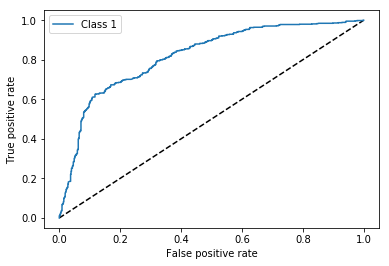

Roc score:  0.818867648470827
Accuracy score:  0.7294028722600151
RANDOM FOREST CLASSIFIER
Classification report:
               precision    recall  f1-score   support

           0       0.72      0.78      0.75       674
           1       0.75      0.68      0.72       649

   micro avg       0.73      0.73      0.73      1323
   macro avg       0.73      0.73      0.73      1323
weighted avg       0.73      0.73      0.73      1323

Confusion matrix:
 [[527 147]
 [206 443]]


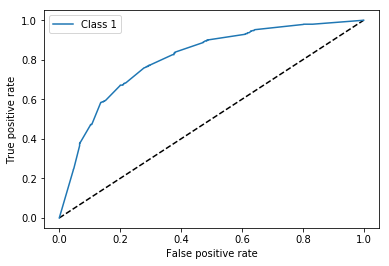

Roc score:  0.8061877894775347
Accuracy score:  0.7331821617535903
DECISION TREE CLASSIFIER
Classification report:
               precision    recall  f1-score   support

           0       0.70      0.70      0.70       674
           1       0.69      0.68      0.69       649

   micro avg       0.69      0.69      0.69      1323
   macro avg       0.69      0.69      0.69      1323
weighted avg       0.69      0.69      0.69      1323

Confusion matrix:
 [[472 202]
 [205 444]]


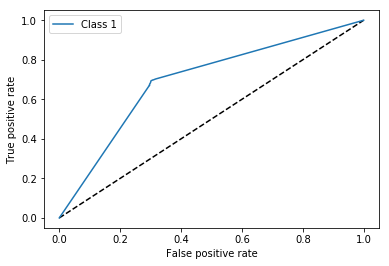

Roc score:  0.6953907632376677
Accuracy score:  0.6923658352229781
SUPPORT VECTOR MACHINE CLASSIFIER


/Users/ian/.pyenv/versions/3.6.5/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Classification report:
               precision    recall  f1-score   support

           0       0.70      0.75      0.72       674
           1       0.72      0.66      0.69       649

   micro avg       0.71      0.71      0.71      1323
   macro avg       0.71      0.71      0.71      1323
weighted avg       0.71      0.71      0.71      1323

Confusion matrix:
 [[504 170]
 [218 431]]


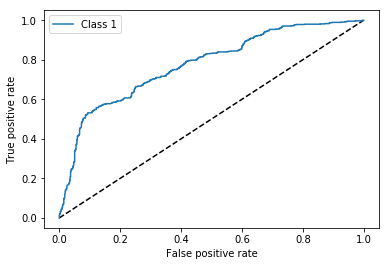

Roc score:  0.7756946317777178
Accuracy score:  0.7067271352985639


In [236]:
# Print model results for undersampling
print("LOGISTIC REGRESSION CLASSIFIER")
get_model_results(X_train_us, y_train_us, X_test_us, y_test_us, clf_lr)
print("RANDOM FOREST CLASSIFIER")
get_model_results(X_train_us, y_train_us, X_test_us, y_test_us, clf_rf)
print("DECISION TREE CLASSIFIER")
get_model_results(X_train_us, y_train_us, X_test_us, y_test_us, clf_dt)
print("SUPPORT VECTOR MACHINE CLASSIFIER")
get_model_results(X_train_us, y_train_us, X_test_us, y_test_us, clf_svm)


LOGISTIC REGRESSION CLASSIFIER


/Users/ian/.pyenv/versions/3.6.5/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classification report:
               precision    recall  f1-score   support

           0       0.74      0.68      0.71     16001
           1       0.71      0.76      0.73     16239

   micro avg       0.72      0.72      0.72     32240
   macro avg       0.72      0.72      0.72     32240
weighted avg       0.72      0.72      0.72     32240

Confusion matrix:
 [[10866  5135]
 [ 3849 12390]]


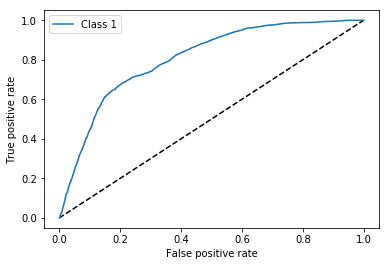

Roc score:  0.8060687244056914
Accuracy score:  0.7213399503722084
RANDOM FOREST CLASSIFIER
Classification report:
               precision    recall  f1-score   support

           0       0.88      0.92      0.90     16001
           1       0.92      0.88      0.90     16239

   micro avg       0.90      0.90      0.90     32240
   macro avg       0.90      0.90      0.90     32240
weighted avg       0.90      0.90      0.90     32240

Confusion matrix:
 [[14728  1273]
 [ 1972 14267]]


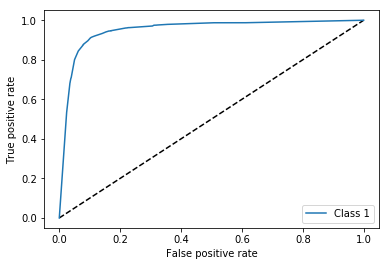

Roc score:  0.9498304013644323
Accuracy score:  0.899348635235732
DECISION TREE CLASSIFIER
Classification report:
               precision    recall  f1-score   support

           0       0.89      0.88      0.88     16001
           1       0.88      0.89      0.89     16239

   micro avg       0.89      0.89      0.89     32240
   macro avg       0.89      0.89      0.89     32240
weighted avg       0.89      0.89      0.89     32240

Confusion matrix:
 [[14071  1930]
 [ 1741 14498]]


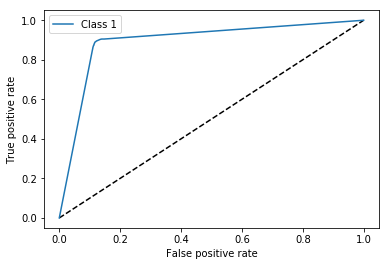

Roc score:  0.8927952321503213
Accuracy score:  0.8861352357320099


In [237]:
# Print model results for oversampling
print("LOGISTIC REGRESSION CLASSIFIER")
get_model_results(X_train_os, y_train_os, X_test_os, y_test_os, clf_lr)
print("RANDOM FOREST CLASSIFIER")
get_model_results(X_train_os, y_train_os, X_test_os, y_test_os, clf_rf)
print("DECISION TREE CLASSIFIER")
get_model_results(X_train_os, y_train_os, X_test_os, y_test_os, clf_dt)
# SVM takes too long to train on a very large dataset
#print("SUPPORT VECTOR MACHINE CLASSIFIER")
#get_model_results(X_train_os, y_train_os, X_test_os, y_test_os, clf_svm)

In [ ]:
#Tweak model parameters for RF
param_grid = {'n_estimators': [15, 55], 'max_features': ['auto', 'log2'],  'max_depth': [4, 20], 'criterion': ['gini', 'entropy']}

model = RandomForestClassifier(random_state=5)

# Combine the parameter sets with the defined model
CV_model_os = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
print("Oversampled:")
# Fit the model to our training data and obtain best parameters
CV_model_os.fit(X_train_os, y_train_os)
print(CV_model_os.best_params_)

# Combine the parameter sets with the defined model
CV_model_us = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
print("Undersampled:")
# Fit the model to our training data and obtain best parameters
CV_model_us.fit(X_train_us, y_train_us)
print(CV_model_us.best_params_)

Classification report:
               precision    recall  f1-score   support

           0       0.78      0.80      0.79       674
           1       0.79      0.77      0.78       649

   micro avg       0.79      0.79      0.79      1323
   macro avg       0.79      0.79      0.79      1323
weighted avg       0.79      0.79      0.79      1323

Confusion matrix:
 [[541 133]
 [149 500]]


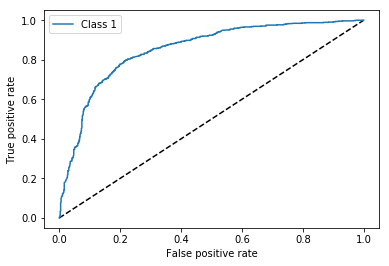

Roc score:  0.8515314590353569
Accuracy score:  0.7868480725623582
Classification report:
               precision    recall  f1-score   support

           0       0.90      0.88      0.89     16001
           1       0.89      0.91      0.90     16239

   micro avg       0.89      0.89      0.89     32240
   macro avg       0.89      0.89      0.89     32240
weighted avg       0.89      0.89      0.89     32240

Confusion matrix:
 [[14120  1881]
 [ 1518 14721]]


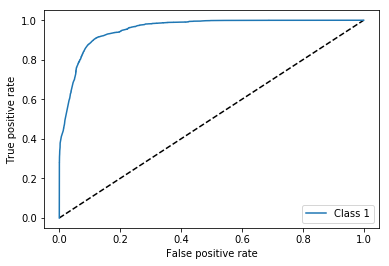

Roc score:  0.9547158167446114
Accuracy score:  0.8945719602977668


In [238]:
clf_rftest_os = RandomForestClassifier(criterion = "gini", max_depth = 20, max_features = "auto", n_estimators = 55, random_state=5)

clf_rftest_us = RandomForestClassifier(criterion = "gini", max_depth = 20, max_features = "auto", n_estimators = 55, random_state=5)
get_model_results(X_train_us, y_train_us, X_test_us, y_test_us, clf_rftest_us)
get_model_results(X_train_os, y_train_os, X_test_os, y_test_os, clf_rftest_os)


Using the defaul values actually gets slightly better results than optimizing with GridSearchCV.

In [169]:
clf_gb = GradientBoostingClassifier(random_state=5)
clf_nb = GaussianNB()

GRADIENT BOOST CLASSIFIER
Classification report:
               precision    recall  f1-score   support

           0       0.86      0.88      0.87     16001
           1       0.88      0.86      0.87     16239

   micro avg       0.87      0.87      0.87     32240
   macro avg       0.87      0.87      0.87     32240
weighted avg       0.87      0.87      0.87     32240

Confusion matrix:
 [[14114  1887]
 [ 2289 13950]]


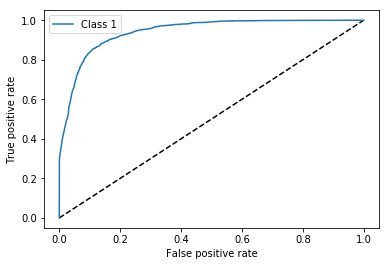

Roc score:  0.941754123386563
Accuracy score:  0.8704714640198511
NAIVE BAYES
Classification report:
               precision    recall  f1-score   support

           0       0.88      0.10      0.19     16001
           1       0.53      0.99      0.69     16239

   micro avg       0.55      0.55      0.55     32240
   macro avg       0.70      0.55      0.44     32240
weighted avg       0.70      0.55      0.44     32240

Confusion matrix:
 [[ 1665 14336]
 [  223 16016]]


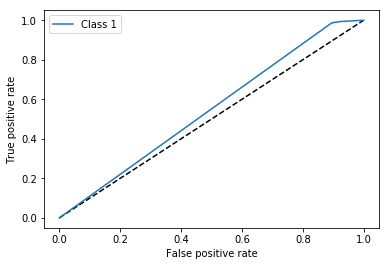

Roc score:  0.5460521955569784
Accuracy score:  0.5484181141439206


In [239]:
print("GRADIENT BOOST CLASSIFIER")
get_model_results(X_train_os, y_train_os, X_test_os, y_test_os, clf_gb)
print("NAIVE BAYES")
get_model_results(X_train_os, y_train_os, X_test_os, y_test_os, clf_nb)

GRADIENT BOOST CLASSIFIER
Classification report:
               precision    recall  f1-score   support

           0       0.79      0.78      0.79       674
           1       0.78      0.79      0.78       649

   micro avg       0.78      0.78      0.78      1323
   macro avg       0.78      0.78      0.78      1323
weighted avg       0.78      0.78      0.78      1323

Confusion matrix:
 [[526 148]
 [139 510]]


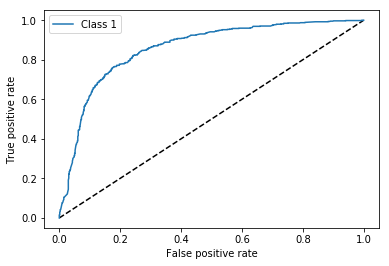

Roc score:  0.8567963495539818
Accuracy score:  0.783068783068783
NAIVE BAYES
Classification report:
               precision    recall  f1-score   support

           0       0.82      0.12      0.20       674
           1       0.51      0.97      0.67       649

   micro avg       0.54      0.54      0.54      1323
   macro avg       0.67      0.54      0.44      1323
weighted avg       0.67      0.54      0.43      1323

Confusion matrix:
 [[ 78 596]
 [ 17 632]]


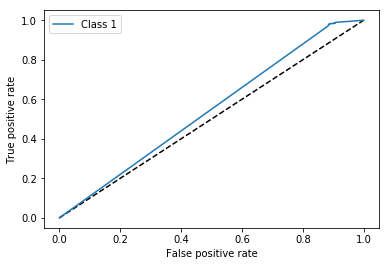

Roc score:  0.5447069904395258
Accuracy score:  0.5366591080876795


In [235]:
print("GRADIENT BOOST CLASSIFIER")
get_model_results(X_train_us, y_train_us, X_test_us, y_test_us, clf_gb)
print("NAIVE BAYES")
get_model_results(X_train_us, y_train_us, X_test_us, y_test_us, clf_nb)

It's unsurprising that naive bayes performs poorly, since it makes assumptions, such as the categories being independent from each other, that we have no reason to think are accurate.

Let's try an ensemble of the different models with good performance that we've used.

In [164]:
ensemble_model = VotingClassifier(estimators=[('dt', clf_dt), ('rf', clf_rf), ('gb', clf_gb)], voting='soft')


UNDER SAMPLED:
Classification report:
               precision    recall  f1-score   support

           0       0.74      0.74      0.74       674
           1       0.73      0.73      0.73       649

   micro avg       0.73      0.73      0.73      1323
   macro avg       0.73      0.73      0.73      1323
weighted avg       0.73      0.73      0.73      1323

Confusion matrix:
 [[496 178]
 [176 473]]


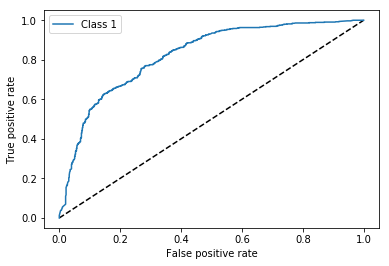

Roc score:  0.8228317475412985
Accuracy score:  0.7324263038548753
OVER SAMPLED:
Classification report:
               precision    recall  f1-score   support

           0       0.90      0.90      0.90     16001
           1       0.90      0.90      0.90     16239

   micro avg       0.90      0.90      0.90     32240
   macro avg       0.90      0.90      0.90     32240
weighted avg       0.90      0.90      0.90     32240

Confusion matrix:
 [[14422  1579]
 [ 1546 14693]]


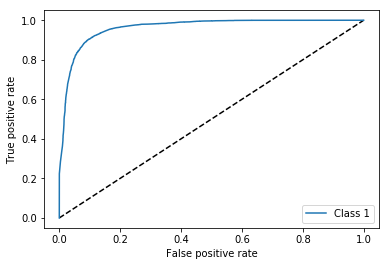

Roc score:  0.9619891167048996
Accuracy score:  0.9030707196029777


In [240]:
print("UNDER SAMPLED:")
get_model_results(X_train_us, y_train_us, X_test_us, y_test_us, ensemble_model)
print("OVER SAMPLED:")
get_model_results(X_train_os, y_train_os, X_test_os, y_test_os, ensemble_model)


It looks like we gain some using an ensemble of the decision tree, random forest, and gradient boost classifiers with over-sampled data.  With a Roc score of 0.902 this is our best score yet.  I'm leaving some code below as a starting point to do Principal Component Analysis to try to reduce the number of features, but since the models above work well it probably isn't that useful.

In [47]:
#transformer = SparsePCA(random_state=0, normalize_components=True)

In [176]:
#svd_us = TruncatedSVD(n_components=5, n_iter=7, random_state=42)

In [185]:
#svd_us.fit(X_undersampled)

In [ ]:
#pca_us = transformer.fit(X_undersampled)

Let's also try xgboost to see how it does.

UNDER SAMPLED:
Classification report:
               precision    recall  f1-score   support

           0       0.79      0.78      0.78       674
           1       0.77      0.79      0.78       649

   micro avg       0.78      0.78      0.78      1323
   macro avg       0.78      0.78      0.78      1323
weighted avg       0.78      0.78      0.78      1323

Confusion matrix:
 [[523 151]
 [136 513]]


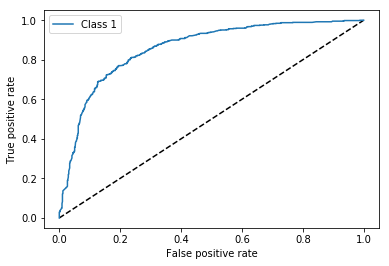

Roc score:  0.8578662448048356
Accuracy score:  0.783068783068783
OVER SAMPLED:
Classification report:
               precision    recall  f1-score   support

           0       0.86      0.88      0.87     16001
           1       0.88      0.86      0.87     16239

   micro avg       0.87      0.87      0.87     32240
   macro avg       0.87      0.87      0.87     32240
weighted avg       0.87      0.87      0.87     32240

Confusion matrix:
 [[14045  1956]
 [ 2272 13967]]


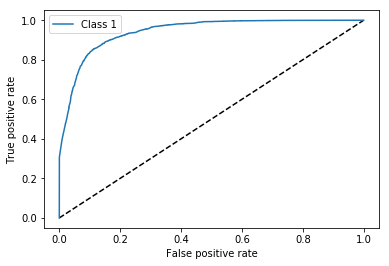

Roc score:  0.9419307800128678
Accuracy score:  0.8688585607940447


In [241]:
clf_xgb = XGBClassifier()
print("UNDER SAMPLED:")
get_model_results(X_train_us, y_train_us, X_test_us, y_test_us, clf_xgb)
print("OVER SAMPLED:")
get_model_results(X_train_os, y_train_os, X_test_os, y_test_os, clf_xgb)

Let's do a validation check to make sure that the model isn't just fitting the oversampled data well.

In [192]:
X_train_val, X_test_val, y_train_val, y_test_val = train_test_split(pred_scaled, target, test_size=0.3, random_state=0)

In [194]:
#Make sure we got enough of Class 1
print(len([i for i in y_train_val if i==1]))
print(len([i for i in y_test_val if i==1]))

1553
652


In [197]:
method_val = SMOTE(kind='regular')

X_val_oversampled, y_val_oversampled = method_val.fit_sample(X_train_val, y_train_val)

In [198]:
ensemble_model.fit(X_val_oversampled, y_val_oversampled)

VotingClassifier(estimators=[('dt', DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fractio...    subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False))],
         flatten_transform=None, n_jobs=None, voting='soft', weights=None)

In [201]:
predicted = ensemble_model.predict(X_test_val)
print("validation accuracy: ", accuracy_score(predicted, y_test_val))

validation accuracy:  0.8904183053271362


  This looks great - we can expect less accuracy since we're training on less data, but it's still 89% accurate and the data used was not oversampled.  Now let's look at the ROC curve on just the data not oversampled.
 

Classification report:
               precision    recall  f1-score   support

           0       0.97      0.91      0.94     16130
           1       0.14      0.35      0.20       652

   micro avg       0.89      0.89      0.89     16782
   macro avg       0.56      0.63      0.57     16782
weighted avg       0.94      0.89      0.91     16782

Confusion matrix:
 [[14714  1416]
 [  423   229]]


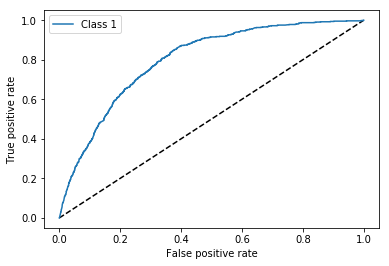

Roc score:  0.7991227336175781
Accuracy score:  0.8904183053271362


In [242]:
ensemble_model.fit(X_val_oversampled, y_val_oversampled)
predicted = ensemble_model.predict(X_test_val)

    # Print the classifcation report and confusion matrix
print('Classification report:\n', classification_report(y_test_val, predicted))
conf_mat = confusion_matrix(y_true=y_test_val, y_pred=predicted)
print('Confusion matrix:\n', conf_mat)
    
y_pred_k = ensemble_model.predict_proba(X_test_val)#.ravel()
fpr=dict()
tpr=dict()
roc_auc=dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test_val, y_pred_k[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    #fpr, tpr, thresholds = roc_curve(ytest.ravel(), y_pred_k)
    #print(set(y_pred_k))
    
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
    #plt.plot(fpr[0], tpr[0], label='Class 0')#, label='Keras (area = {:.3f})'.format(auc_keras))
plt.plot(fpr[1], tpr[1], label='Class 1')# (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
    #plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
print("Roc score: ", roc_auc_score(y_test_val, y_pred_k[:, 1]))
print("Accuracy score: ", accuracy_score(predicted, y_test_val))

Let's add some images now to visualize what's going on.

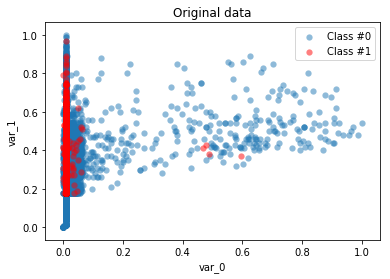

In [207]:
plot_data(np.array(pred_scaled), target, title="Original data")

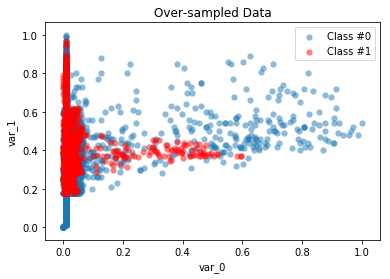

In [208]:
plot_data(np.array(X_oversampled), y_oversampled, title="Over-sampled Data")

In [209]:
clf_dt.fit(X_train_os, y_train_os)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=5,
            splitter='best')

In [210]:
from sklearn.tree import export_graphviz
from sklearn import tree
from IPython.display import SVG
from graphviz import Source
from IPython.display import display

In [214]:
labels = predictors.columns.values
print(labels)

['var_0' 'var_1' 'var_2' 'var_3' 'var_4' 'var_5' 'var_6' 'var_7' 'var_8'
 'var_9' 'var_10' 'var_11' 'var_12' 'var_13' 'var_14' 'var_15' 'var_16'
 'var_17' 'var_18' 'var_19' 'var_20' 'var_21' 'var_22' 'var_23' 'var_24'
 'var_25' 'var_26' 'var_27' 'var_28' 'var_29' 'var_30' 'var_31' 'var_32'
 'var_33' 'var_34' 'var_35' 'var_36' 'var_37' 'var_38' 'var_39' 'var_40'
 'var_41' 'var_42' 'var_43' 'var_44' 'var_45' 'var_46' 'var_47' 'var_48'
 'var_49' 'var_50' 'var_51' 'var_52' 'var_53' 'var_54' 'var_55' 'var_56'
 'var_57' 'var_58' 'var_59' 'var_60' 'var_61' 'var_62' 'var_63' 'var_64'
 'var_65' 'var_66' 'var_67' 'var_68' 'var_69' 'var_70' 'var_71' 'var_72'
 'var_73' 'var_74' 'var_75' 'var_76' 'var_77' 'var_78' 'var_79' 'var_80'
 'var_81' 'var_82' 'var_83' 'var_84' 'var_85' 'var_86' 'var_87' 'var_88'
 'var_89' 'var_90' 'var_91' 'var_92' 'var_93' 'var_94' 'var_95' 'var_96'
 'var_97' 'var_98' 'var_99' 'var_100' 'var_101' 'var_102' 'var_103'
 'var_104' 'var_105' 'var_106' 'var_107' 'var_108' 'var_1

In [229]:
#graph = Source(tree.export_graphviz(clf_dt, out_file=None
#   , feature_names=labels, class_names=['0', '1'] 
#   , filled = True))
#display(SVG(graph.pipe(format='svg')))

In [ ]:
graph.render("tree")